# Change points detection algorithm for keypoint data
- From keypoint MoSeq
- Basseville, M., and Nikiforov, I.V. (1993). Detection of abrupt changes (Prentice-Hall Publishing).

In [2]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# --Machine learning and statistics
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelmax, argrelextrema
from scipy.stats import zscore
from scipy.stats import ttest_1samp
from functools import reduce

from one.api import ONE
one = ONE()

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import timeseries_PSTH, prepro


## Parameters

In [3]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

In [18]:
h = 0.05  # thresold??
sigma = 0.1  # for Gaussian filter

shuffle_iters = 1000

## Preprocess list of design matrices

In [4]:
# Save data of all sessions for latter
mouse_names = []

for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    if m == 0:
        mouse_names = mouse_name
    else:
        mouse_names = np.hstack((mouse_names, mouse_name))

In [14]:

# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for mouse_name in mouse_names:

    for m, mat in enumerate(design_matrices):
        
        if (mouse_name in mat) & (len(mouse_name) > 0): 
            
            # Trials data
            session = design_matrices[m][14:50]
                
            session_trials = one.load_object(session, obj='trials', namespace='ibl')
            session_trials = session_trials.to_df()
            session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
            session_start = list(session_trials['stimOn_times'])[0]

            # Get time of last unbiased trial
            unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
            time_trial_90 = list(unbiased['stimOff_times'])[-1]
            
            big_design_matrix = pickle.load(open(mat, "rb"))
            design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
            design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
            design_matrix = design_matrix.dropna()
        
            # Keep only first 90 trials
            design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
            design_matrix['Lick count'] = gaussian_filter1d(design_matrix['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
            unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
            training_set = np.array(design_matrix[var_names]).copy() 
            
            if len(training_set) > 0:
                # Standardization using StandardScaler
                scaler = StandardScaler()
                standardized = scaler.fit_transform(training_set)
                # Normalize between 0 and 1
                normalizer = Normalizer().fit(standardized)
                normalized = normalizer.transform(standardized)
            
            # Save results per mouse
            matrix_all[mouse_name].append(normalized)
            session_all[mouse_name].append(unbiased_trials)    
            matrix_all_unnorm[mouse_name].append(design_matrix) 

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        matrix_all[mouse] = np.vstack(matrix_all[mouse])
        matrix_all_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse])
        session_all[mouse] = pd.concat(session_all[mouse], ignore_index=True)

## Functions

In [15]:
def changepoints(use_data, h):
        
    features = use_data.keys()

    # Derivative
    derivative = use_data.copy()
    for i, feat in enumerate(features):
        derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

    # z-score
    df_zscore = derivative[np.array(features)]
    thresholded = df_zscore.apply(zscore, nan_policy='omit')

    # Threshold
    for i, feat in enumerate(features):
        # thresholded[pc] = thresholded[pc] * np.nan
        thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
        thresholded.loc[thresholded[feat] > h, feat] = 1
        thresholded.loc[thresholded[feat] < -h, feat] = 1

    # Sum
    summed_threshold = np.sum(thresholded, axis=1)

    # # Smooth
    # smoothed_signal = gaussian_filter1d(summed_threshold, sigma=sigma)
        
    # return smoothed_signal
    return summed_threshold


def cyclic_permutation(use_data):
    
    permuted_data = use_data.copy()
    
    features = use_data.keys()
    for f, feat in enumerate(features):
        # Generate a random interval for cyclic permutation
        random_interval = np.random.randint(1, np.shape(use_data)[0])

        # Cyclically permute the time series
        permuted_data[feat] = np.roll(use_data[feat], random_interval)

    return permuted_data


def shuffled(use_data, shuffle_iters, h):
    
    changepoints_shuffled = np.zeros((shuffle_iters, np.shape(use_data)[0]))
    
    features = use_data.keys()

    for s in range(shuffle_iters):
        
        # Randomly permute each keypoint timeseries
        permuted_data = cyclic_permutation(use_data)

        # Derivative
        derivative = permuted_data.copy()
        for i, feat in enumerate(features):
            derivative[feat] = derivative[feat].shift(-3) + derivative[feat].shift(-2) + derivative[feat].shift(-1) - derivative[feat].shift(1) - derivative[feat].shift(2) - derivative[feat].shift(3) 

        # z-score 
        df_zscore = derivative[np.array(features)]
        thresholded = df_zscore.apply(zscore, nan_policy='omit')

        # Threshold
        for i, feat in enumerate(features):
            # thresholded[pc] = thresholded[pc] * np.nan
            thresholded.loc[(thresholded[feat] >= -h) & (thresholded[feat] <= h), feat] = 0
            thresholded.loc[thresholded[feat] > h, feat] = 1
            thresholded.loc[thresholded[feat] < -h, feat] = 1

        # Sum
        summed_threshold = np.sum(thresholded, axis=1)

        # Save
        changepoints_shuffled[s, :] = summed_threshold
    return changepoints_shuffled


def peaks(use_data, h, shuffle_iters):
    
    data_changepoints = changepoints(use_data, h)
    shuffle_changepoints = shuffled(use_data, shuffle_iters, h)

    timesteps = np.shape(use_data)[0]
    change_score = np.zeros((timesteps))
    p_values = np.zeros((timesteps))
    bigger = np.zeros((timesteps))

    # 1-sample t-test to compare data changepoints to shuffled distribution
    for t in range(timesteps):

        # Perform one-sample t-test
        _, p_value = ttest_1samp(shuffle_changepoints[:, t], data_changepoints[t])
        
        # To avoid numerical error
        if p_value == 0:
            p_value = 0.00000001
        
        p_values[t] = p_value
        change_score[t] = -np.log10(p_value)

        # Check if data changepoints is higher than shuffle
        if data_changepoints[t] > np.mean(shuffle_changepoints[:, t]):
            bigger[t] = 1
        else:
            bigger[t] = 0
            p_values[t] = -p_values[t]

    # Smooth change_score
    smooth_score = gaussian_filter1d(change_score, sigma=1)
    # Detect local maxima
    local_maxima = argrelmax(smooth_score)  # , np.greater
    significant = np.where(np.abs(p_values)< 0.01)
    bigger_than_threshold = np.where(bigger==1)

    # Find intersection of peaks significantly above permuted
    intersect = reduce(np.intersect1d, (significant, local_maxima, bigger_than_threshold))

    return smooth_score, data_changepoints, shuffle_changepoints, intersect, p_values, change_score

In [35]:
# Prepare grid
hs = [0.06, 0.07, 0.08, 0.09, 0.1, 0.15]
hs = [0.08, 0.1, 0.12, 0.15]

all_medians = defaultdict(list)

# Loop through mice
for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    if len(mouse_name) > 0:
        try:
            # Get mouse data
            session_trials = session_all[mouse_name]
            design_matrix = matrix_all[mouse_name]
            unnorm_mat = matrix_all_unnorm[mouse_name]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
                
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix
            bins = unnorm_mat['Bin']
            design_matrix_heading['Bin'] = bins
            
            " Do grid search "
            results_data = {}
            smoothed_data = {}
            results_control ={}
            summary_results = {}
                
            for i, h in enumerate(hs):
                results_data[h] = {}
                smoothed_data[h] = {}
                results_control[h] = {}
                summary_results[h] = {}

                change_score, data_changepoints, shuffle_changepoints, intersect, p_values, non_filtered_score = peaks(design_matrix_heading, h, shuffle_iters)
                
                """ Save results """
                results_data[h] = data_changepoints 
                smoothed_data[h] = change_score
                results_control[h] = shuffle_changepoints 
                summary_results[h] = len(intersect)
                
            " Maximize changepoints "
            list_changepoints = []
            keys = []

            for ih, h in enumerate(hs):

                if len(list_changepoints) == 0:
                    list_changepoints = [summary_results[h]]
                    keys = [h]
                else:
                    list_changepoints = np.vstack((list_changepoints, summary_results[h]))
                    keys = np.vstack((keys, [h]))
                                    
            if len(list_changepoints) > 0:

                # Choose parameters
                flat_changepoints = list_changepoints.ravel()
                use_keys = keys[flat_changepoints==np.max(flat_changepoints)]

                # Calculate changepoints based on optimal parameters
                h = float(use_keys[0])

            # Calculate median
            change_score, data_changepoints, shuffle_changepoints, intersect, p_values, non_filtered_score = peaks(design_matrix_heading, h, shuffle_iters)
            # Save best param
            all_medians[mouse_name] = np.median(np.diff(intersect))
            
        except:
            print(mouse_name)


DY_016
PL017
SWC_058
ZFM-01936
ibl_witten_29


In [37]:
all_medians

defaultdict(list,
            {'CSHL060': 6.0,
             'DY_013': 6.0,
             'DY_014': 6.0,
             'KS096': 6.0,
             'NYU-40': 6.0,
             'PL015': 6.0,
             'PL016': 6.0,
             'SWC_053': 6.0})

All mice had median block duration = 600 ms

## Visualize results

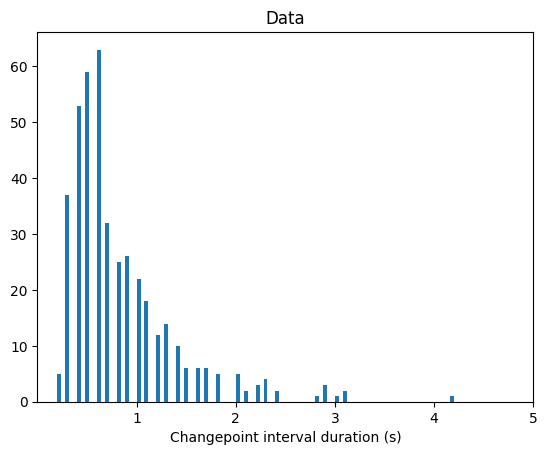

6.0


In [20]:
plt.hist(np.diff(intersect), bins=100)
plt.xlim([0, 50])
plt.xlabel('Changepoint interval duration (s)')
plt.xticks([10, 20, 30, 40, 50], [1, 2, 3, 4, 5])
plt.title('Data')
plt.show()

print(np.median(np.diff(intersect)))
